# DarwinAI Explain for Image Classification in PyTorch
<br>
<font size= 4>
This notebook demonstrates DarwinAI Explain for providing quantitative explanations and justifications for the decisions made by an image classification model in PyTorch.
</font>

## Getting started
To use DarwinAI, install the following python version, packages and license: 
![title](darwinai_docker.png)

Instructions and license can be found on Platypus in directory: /home/gensynth/darwinai-sdk-0.30.0. 
After successful installation of the above, run this jupyter notebook in the remote server. 

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision
import torchvision.models as models
import torch
import cv2
from utils.imagenet_classes import imagenet_class_names as class_names

In [2]:
# The DarwinAI SDK import
from darwinai.torch.explain import image_classification_explain

22-04-24 21:00:06.392|INFO|<frozen importlib._bootstrap>|_load_backward_compatible|618|LicensingClient|License activated successfully.


The DarwinAI troubleshooting mode is active and debug logs are stored at /home/jessy.song/prototypical_network/darwinai_explain/logs/darwin_sdk_2022-04-24T21:00:06.debug.


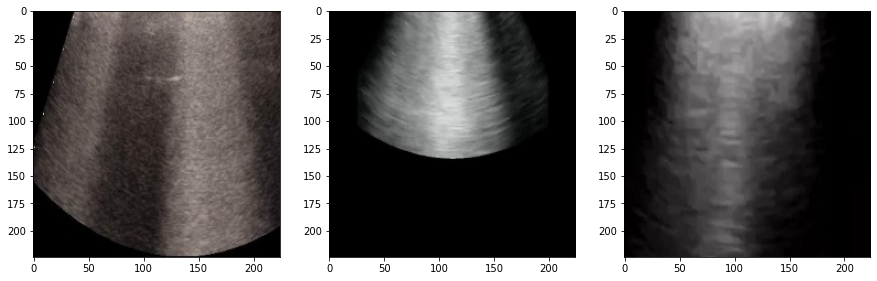

In [15]:
# Load and visualize the input images
IM_W = 224
IM_H = 224

image_names = ['cropped_true_pos_1_orig', 
               'cropped_true_pos_2_orig', 
               'cropped_true_pos_4_orig']
image_paths = []
for i in image_names: 
    path = f'./images/{i}.jpg'
    image_paths.append(os.path.join(path))

images = np.stack(
    [np.array(Image.open(p).resize((IM_W, IM_H))) for p in image_paths],
    axis=0
)

# Visualize the images
f, ax = plt.subplots(1, 3, figsize=(15,15))
for i, im in enumerate(images):
    ax[i].imshow(im)

In [16]:
# Image preprocessing:
# 1. Convert PIL.Image to torch.Tensor.
# 2. Normalize the image to expected mean and stddev for imagenet pretrained model.
transform = transforms.Compose(
    [
        transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # no normalization is done on ultrasound images. 
        transforms.Resize((224, 224)),
    ]
)
images_normalized = torch.stack([transform(i) for i in images])

In [17]:
# In this example we'll use the resnet18 model
model = models.resnet18(pretrained=True)
model.eval()

last_conv_layers = [model.layer4[-1]]

In [18]:
# Call DarwinAI Explain function
explanations, conf_criticalfactors, conf_alternativefactors = image_classification_explain(
    images_normalized, model, last_conv_layers
)

conf_criticalfactors = conf_criticalfactors.detach().numpy()
conf_alternativefactors = conf_alternativefactors.detach().numpy()

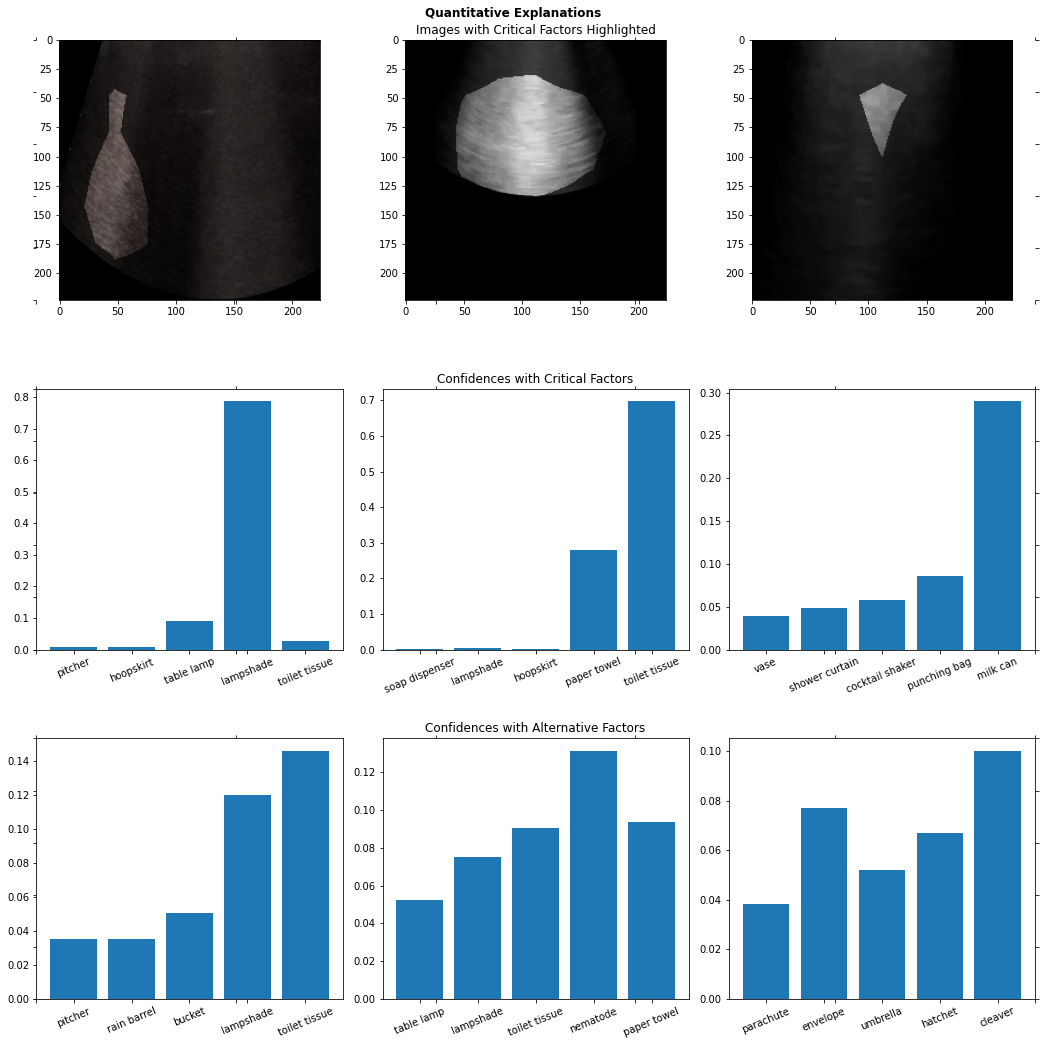

In [19]:
# Visualize quantitative explanations
n_rows = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=1, sharey=True, figsize=(15.0, 15.0))
fig.suptitle("Quantitative Explanations", fontweight="bold")
subtitles = [
    'Images with Critical Factors Highlighted',
    'Confidences with Critical Factors',
    'Confidences with Alternative Factors'
]

for row, ax in enumerate(axes):
    ax.set_title(subtitles[row])
    ax.tick_params(labelcolor=(1., 1., 1., 0.0), top='off', bottom='off', left='off', right='off')
    ax._frameon = False

offset = 1
for i in range(0, images.shape[0]): # Original images
    image = images[i]
    explanation = np.stack((explanations[i, ...],) * 3, axis=-1)
    explanation_overlay = image * np.clip(0.3 + (explanation > 0), 0, 1)
    explanation_overlay = explanation_overlay.squeeze()
    explanation_overlay = explanation_overlay.astype(np.uint8)
    ax = fig.add_subplot(n_rows, images.shape[0], i + offset)
    ax.imshow(explanation_overlay)
    
    # save annotated image. 
    cam_image = cv2.cvtColor(explanation_overlay, cv2.COLOR_RGB2BGR)
    cam_path = f'./annotated_images/{image_names[i]}.jpg'
    cv2.imwrite(os.path.join(cam_path),cam_image)  
    
offset += images.shape[0]
for i in range(0, images.shape[0]): # Critical factor confidences
    conf = conf_criticalfactors[i]
    inds = np.argpartition(conf, -5)[-5:]
    vals = [conf[c] for c in inds]
    names = [class_names[c].split(',')[0] for c in inds]
    ax = fig.add_subplot(n_rows, images.shape[0], i + offset)
    ax.bar(names, vals)
    ax.tick_params(axis='x', labelrotation=22.5)

offset += images.shape[0]
for i in range(0, images.shape[0]): # Critical factor confidences
    conf = conf_alternativefactors[i]
    inds = np.argpartition(conf, -5)[-5:]
    vals = [conf[c] for c in inds]
    names = [class_names[c].split(',')[0] for c in inds]
    ax = fig.add_subplot(n_rows, images.shape[0], i + offset)
    ax.bar(names, vals)
    ax.tick_params(axis='x', labelrotation=22.5)
    
fig.set_facecolor('w')
plt.tight_layout()
plt.show()